<a href="https://colab.research.google.com/github/Saimohith2402/VolGaurd/blob/main/VolGaurd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install yfinance xgboost scikit-learn pandas numpy matplotlib shap


In [ ]:
import os
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
import shap
import yfinance as yf

In [ ]:
TICKER = "^NSEI"
START = "2019-01-01"
END = dt.date.today().isoformat()
REALIZED_WINDOW = 5
MODEL_SEED = 42
OUTPUT_DIR = "vol_forecast_output_split"
os.makedirs(OUTPUT_DIR, exist_ok=True)
TRAIN_END = "2024-12-31"
TEST_START = "2025-01-01"
TEST_END = "2025-10-31"

In [ ]:
RISK_MULTIPLIER = 1.2

In [ ]:
XGB_PARAMS = {
    "objective": "reg:squarederror",
    "tree_method": "hist",
    "eta": 0.05,
    "max_depth": 4,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "seed": MODEL_SEED,
    "verbosity": 0,
    "eval_metric": "rmse",
}
NUM_BOOST_ROUND = 1000
EARLY_STOPPING_ROUNDS = 50

In [ ]:
def ensure_date(s):
    if isinstance(s, (dt.date, dt.datetime)):
        return pd.to_datetime(s).date()
    return pd.to_datetime(s).date()
TRAIN_END = ensure_date(TRAIN_END)
TEST_START = ensure_date(TEST_START)
TEST_END = ensure_date(TEST_END)
assert TRAIN_END < TEST_START, "TRAIN_END should be before TEST_START to avoid leakage."

In [ ]:
print(f"Downloading {TICKER} data from {START} to {END} ...")
try:
    raw = yf.download(TICKER, start=START, end=END, progress=False)
    if raw.shape[0] == 0:
        raise RuntimeError("yfinance returned no data.")
except Exception as e:
    print("yfinance download failed:", e)
    raise
raw = raw.rename(columns=lambda s: s.strip())
if "Close" not in raw.columns and "Adj Close" in raw.columns:
    raw["Close"] = raw["Adj Close"]
df = raw[["Close"]].copy().dropna()
df.index = pd.to_datetime(df.index).normalize()
print(f"Downloaded {len(df)} rows of data. First date: {df.index.min().date()}, Last date: {df.index.max().date()}")

Downloaded 1690 rows of data. First date: 2019-01-02, Last date: 2025-11-07


In [ ]:
print("Building features (robust handling of Series vs DataFrame)...")
close_ser = df["Close"].squeeze()
ret = np.log(close_ser / close_ser.shift(1))
ma5 = close_ser.rolling(5).mean()
ma10 = close_ser.rolling(10).mean()
vol_5d = ret.rolling(5).std()
vol_10d = ret.rolling(10).std()
atr5 = close_ser.rolling(5).apply(lambda x: np.max(x) - np.min(x), raw=True)

Building features (robust handling of Series vs DataFrame)...


In [ ]:
data = pd.DataFrame(index=df.index)
data["Close"] = close_ser
data["Return"] = ret
data["Realized_Vol"] = ret.rolling(window=REALIZED_WINDOW).std() * np.sqrt(252)
data["Lag1"] = ret.shift(1)
data["Lag2"] = ret.shift(2)
data["MA5"] = ma5
data["MA10"] = ma10
data["Vol_5d"] = vol_5d
data["Vol_10d"] = vol_10d
data["Moneyness_proxy"] = np.where(ma10 == 0, np.nan, close_ser / ma10)
data["ATR5"] = atr5
data["Target"] = data["Realized_Vol"].shift(-1)


In [ ]:
data = data.dropna().copy()
print(f"After feature building, rows available: {len(data)}. Date range: {data.index.min().date()} to {data.index.max().date()}")


After feature building, rows available: 1679. Date range: 2019-01-16 to 2025-11-06


In [ ]:
if TRAIN_END < data.index.min().date():
    raise ValueError("TRAIN_END is earlier than earliest available feature date.")
if TEST_START < data.index.min().date():
    raise ValueError("TEST_START is earlier than earliest available feature date.")
if TEST_END > data.index.max().date():
    raise ValueError("TEST_END is later than latest available date with features/target.")

In [ ]:
train_mask = (data.index.date <= TRAIN_END)
test_mask = (data.index.date >= TEST_START) & (data.index.date <= TEST_END)

train_df = data.loc[train_mask].copy()
test_df = data.loc[test_mask].copy()

In [ ]:
train_df

,Close,Return,Realized_Vol,Lag1,Lag2,MA5,MA10,Vol_5d,Vol_10d,Moneyness_proxy,ATR5,Target
Date,,,,,,,,,,,,
2019-01-16,10890.299805,0.000321,0.121021,0.013799,-0.005327,10826.249805,10795.994922,0.007624,0.006892,1.008735,152.700195,0.116385
2019-01-17,10905.200195,0.001367,0.116385,0.000321,0.013799,10842.969922,10819.289941,0.007332,0.005429,1.007940,167.600586,0.112107
2019-01-18,10906.950195,0.000160,0.112107,0.001367,0.000321,10865.369922,10837.250000,0.007062,0.005353,1.006432,169.350586,0.091257
2019-01-21,10961.849609,0.005021,0.091257,0.000160,0.001367,10910.219922,10856.254980,0.005749,0.005405,1.009727,75.049805,0.048801
2019-01-22,10922.750000,-0.003573,0.048801,0.005021,0.000160,10917.409961,10868.314941,0.003074,0.005638,1.005009,71.549805,0.081096
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-24,23727.650391,-0.001087,0.136155,0.007011,-0.015322,23843.829688,24218.219922,0.008577,0.008060,0.979744,611.349609,0.142286
2024-12-26,23750.199219,0.000950,0.142286,-0.001087,0.007011,23754.099609,24129.059766,0.008963,0.008038,0.984299,364.199219,0.134317
2024-12-27,23813.400391,0.002658,0.134317,0.000950,-0.001087,23726.439844,24055.529883,0.008461,0.008283,0.989935,225.900391,0.082311


In [ ]:
test_df

,Close,Return,Realized_Vol,Lag1,Lag2,MA5,MA10,Vol_5d,Vol_10d,Moneyness_proxy,ATR5,Target
Date,,,,,,,,,,,,
2025-01-01,23742.900391,0.004140,0.068944,-0.000004,-0.007101,23719.240234,23781.534961,0.004343,0.006969,0.998375,168.599609,0.149268
2025-01-02,24188.650391,0.018600,0.149268,0.004140,-0.000004,23806.930469,23780.515039,0.009403,0.009498,1.017163,543.849609,0.170042
2025-01-03,24004.750000,-0.007632,0.170042,0.018600,0.004140,23845.200391,23785.820117,0.010712,0.009216,1.009204,543.849609,0.208125
2025-01-06,23616.050781,-0.016325,0.208125,-0.007632,0.018600,23839.430469,23788.675195,0.013111,0.009407,0.992743,572.599609,0.210225
2025-01-07,23707.900391,0.003882,0.210225,-0.016325,-0.007632,23852.050391,23784.120312,0.013243,0.009202,0.996795,572.599609,0.207796
...,...,...,...,...,...,...,...,...,...,...,...,...
2025-10-27,25966.050781,0.006603,0.064629,-0.003724,0.000881,25872.870312,25635.590234,0.004071,0.004834,1.012891,170.900391,0.060428
2025-10-28,25936.199219,-0.001150,0.060428,0.006603,-0.003724,25891.480078,25706.475195,0.003807,0.004716,1.008936,170.900391,0.066355
2025-10-29,26053.900391,0.004528,0.066355,-0.001150,0.006603,25928.540234,25797.315234,0.004180,0.004229,1.009946,258.750000,0.088818


In [ ]:
print(f"Train rows: {len(train_df)} (<= {TRAIN_END})")
print(f"Test rows:  {len(test_df)} (from {TEST_START} to {TEST_END})")

Train rows: 1468 (<= 2024-12-31)
Test rows:  208 (from 2025-01-01 to 2025-10-31)


In [ ]:
if len(train_df) < 20:
    raise ValueError("Not enough training rows after split - increase START or TRAIN_END.")
if len(test_df) < 1:
    raise ValueError("No test rows found in the requested test window.")

In [ ]:
FEATURES = ["Lag1", "Lag2", "MA5", "MA10", "Vol_5d", "Vol_10d", "Moneyness_proxy", "ATR5"]

In [ ]:
X_train = train_df[FEATURES].values
y_train = train_df["Target"].values
X_test = test_df[FEATURES].values
y_test = test_df["Target"].values

In [ ]:
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=FEATURES)
dtest = xgb.DMatrix(X_test, label=y_test, feature_names=FEATURES)

In [ ]:
watchlist = [(dtrain, "train"), (dtest, "eval")]

In [ ]:
print("Training with xgb.train (DMatrix API)...")
bst = xgb.train(
    params=XGB_PARAMS,
    dtrain=dtrain,
    num_boost_round=NUM_BOOST_ROUND,
    evals=watchlist,
    early_stopping_rounds=EARLY_STOPPING_ROUNDS,
    verbose_eval=False
)
model_path = os.path.join(OUTPUT_DIR, "xgb_model.json")
bst.save_model(model_path)
print("Saved model to", model_path)

Training with xgb.train (DMatrix API)...
Saved model to vol_forecast_output_split/xgb_model.json


In [ ]:
y_pred = bst.predict(dtest)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)


In [ ]:
print("\nTest metrics:")
print(f"MAE = {mae:.6f}")
print(f"RMSE = {rmse:.6f}")
print(f"R^2 = {r2:.4f}")


Test metrics:
MAE = 0.021170
RMSE = 0.032334
R^2 = 0.7108


In [ ]:
results = test_df[["Close", "Realized_Vol"]].copy()
results = results.assign(Predicted_Vol=y_pred, Actual_NextDay_Vol=y_test)
results["Pred_Rolling_Mean_10"] = results["Predicted_Vol"].rolling(10, min_periods=1).mean()
results["Risk_Flag"] = np.where(results["Predicted_Vol"] > results["Pred_Rolling_Mean_10"] * RISK_MULTIPLIER, "HIGH_RISK", "NORMAL")

out_csv = os.path.join(OUTPUT_DIR, "vol_forecast_results_dmatrix.csv")
results.to_csv(out_csv)
print("Saved results to", out_csv)

Saved results to vol_forecast_output_split/vol_forecast_results_dmatrix.csv


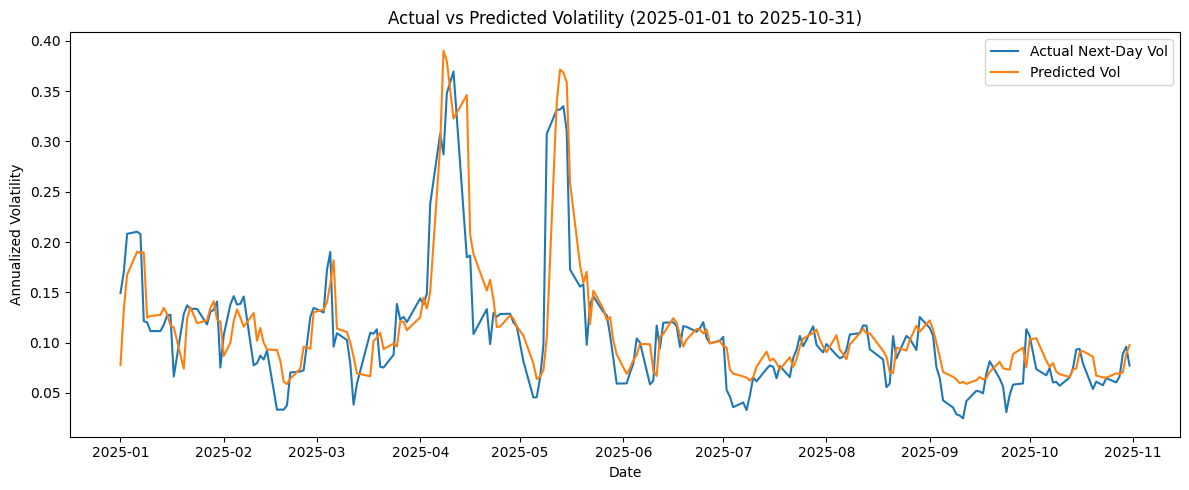

Saved plot to vol_forecast_output_split/actual_vs_predicted_dmatrix.png


In [ ]:
plt.figure(figsize=(12,5))
plt.plot(results.index, results["Actual_NextDay_Vol"], label="Actual Next-Day Vol")
plt.plot(results.index, results["Predicted_Vol"], label="Predicted Vol")
plt.title(f"Actual vs Predicted Volatility ({TEST_START} to {TEST_END})")
plt.xlabel("Date")
plt.ylabel("Annualized Volatility")
plt.legend()
png1 = os.path.join(OUTPUT_DIR, "actual_vs_predicted_dmatrix.png")
plt.tight_layout()
plt.savefig(png1)
plt.show()
print("Saved plot to", png1)

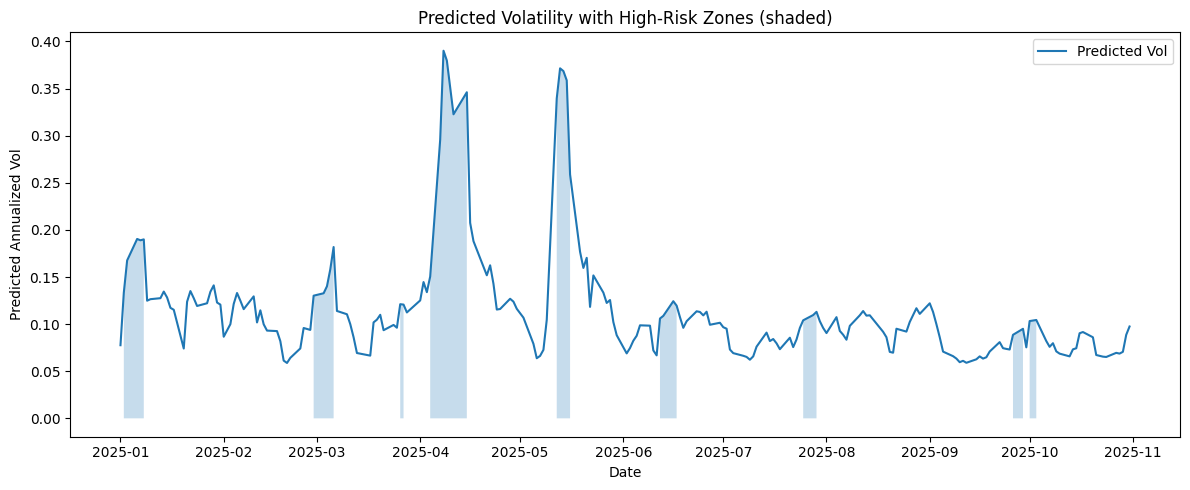

Saved plot to vol_forecast_output_split/predicted_vol_riskzones_dmatrix.png


In [ ]:
plt.figure(figsize=(12,5))
plt.plot(results.index, results["Predicted_Vol"], label="Predicted Vol")
high_mask = results["Risk_Flag"] == "HIGH_RISK"
if high_mask.any():
    plt.fill_between(results.index, 0, results["Predicted_Vol"], where=high_mask, alpha=0.25)
plt.title("Predicted Volatility with High-Risk Zones (shaded)")
plt.xlabel("Date")
plt.ylabel("Predicted Annualized Vol")
plt.legend()
png2 = os.path.join(OUTPUT_DIR, "predicted_vol_riskzones_dmatrix.png")
plt.tight_layout()
plt.savefig(png2)
plt.show()
print("Saved plot to", png2)

In [ ]:
try:
    fmap = bst.get_score(importance_type="gain")
    fi = pd.DataFrame({
        "feature": list(fmap.keys()),
        "importance": list(fmap.values())
    })
    fi = fi.sort_values("importance", ascending=False)
    fi_path = os.path.join(OUTPUT_DIR, "feature_importances_dmatrix.csv")
    fi.to_csv(fi_path, index=False)
    print("Saved feature importances to", fi_path)
    print("\nTop feature importances:")
    print(fi.head().to_string(index=False))
except Exception as e:
    print("Feature importances failed:", e)

Saved feature importances to vol_forecast_output_split/feature_importances_dmatrix.csv

Top feature importances:
        feature  importance
         Vol_5d    0.390789
        Vol_10d    0.223445
           ATR5    0.030850
Moneyness_proxy    0.023794
            MA5    0.022455


In [ ]:
print("\nRunning SHAP explainability (robust multi-approach)...")
try:
    import shap
except Exception as e:
    print("shap not installed or import failed:", e)
    shap = None

if shap is None:
    print("SHAP not available. Install via: pip install shap")
else:
    X_test_df = pd.DataFrame(X_test, columns=FEATURES)

    def try_shap_booster(booster, Xdf):
        expl = shap.TreeExplainer(booster)
        return expl(Xdf)

    def try_shap_wrapper(model_json_path, Xdf):
        from xgboost import XGBRegressor
        wrapper = XGBRegressor()
        wrapper.load_model(model_json_path)
        expl = shap.TreeExplainer(wrapper)
        return expl(Xdf)

    def try_shap_function(booster, Xdf):
        predict_fn = lambda X: booster.predict(xgb.DMatrix(X, feature_names=FEATURES))
        expl = shap.Explainer(predict_fn, Xdf, feature_names=FEATURES)
        return expl(Xdf)

    shap_values = None
    model_json = model_path
    try:
        shap_values = try_shap_booster(bst, X_test_df)
        print("SHAP: used TreeExplainer on Booster (fast path).")
    except Exception as e1:
        print("SHAP: TreeExplainer(bst) failed:", e1)
        try:
            if os.path.exists(model_json):
                shap_values = try_shap_wrapper(model_json, X_test_df)
                print("SHAP: loaded model into XGBRegressor and used TreeExplainer.")
            else:
                raise FileNotFoundError("Model JSON not found.")
        except Exception as e2:
            print("SHAP: TreeExplainer via sklearn wrapper failed:", e2)
            try:
                shap_values = try_shap_function(bst, X_test_df)
                print("SHAP: used shap.Explainer on predict function (fallback).")
            except Exception as e3:
                print("SHAP: fallback explainer failed:", e3)
                shap_values = None

    if shap_values is None:
        print("SHAP analysis unavailable. Ensure 'shap' and compatible 'xgboost' are installed.")
    else:
        try:
            plt.figure()
            shap.summary_plot(shap_values, X_test_df, show=False)
            shap_png1 = os.path.join(OUTPUT_DIR, "shap_summary_beeswarm.png")
            plt.savefig(shap_png1, bbox_inches='tight')
            plt.close()
            print("Saved SHAP beeswarm to", shap_png1)
        except Exception as e:
            print("Failed to save SHAP beeswarm:", e)
        try:
            plt.figure()
            shap.summary_plot(shap_values, X_test_df, plot_type="bar", show=False)
            shap_png2 = os.path.join(OUTPUT_DIR, "shap_summary_bar.png")
            plt.savefig(shap_png2, bbox_inches='tight')
            plt.close()
            print("Saved SHAP bar to", shap_png2)
        except Exception as e:
            print("Failed to save SHAP bar:", e)
        try:
            mean_abs = np.abs(shap_values.values).mean(0)
            top_idxs = np.argsort(mean_abs)[-3:][::-1]
            for idx in top_idxs:
                fname = FEATURES[idx]
                plt.figure()
                shap.dependence_plot(fname, shap_values.values, X_test_df, show=False)
                dep_png = os.path.join(OUTPUT_DIR, f"shap_dependence_{fname}.png")
                plt.savefig(dep_png, bbox_inches='tight')
                plt.close()
                print(f"Saved SHAP dependence plot for {fname} to", dep_png)
        except Exception as e:
            print("Failed to create SHAP dependence plots:", e)

print("✅ SHAP analysis (attempted).")


Running SHAP explainability (robust multi-approach)...
SHAP: TreeExplainer(bst) failed: could not convert string to float: '[1.4206997E-1]'
SHAP: TreeExplainer via sklearn wrapper failed: could not convert string to float: '[1.4206997E-1]'


ExactExplainer explainer: 209it [00:10,  1.82it/s]                         


SHAP: used shap.Explainer on predict function (fallback).
Saved SHAP beeswarm to vol_forecast_output_split/shap_summary_beeswarm.png
Saved SHAP bar to vol_forecast_output_split/shap_summary_bar.png
Saved SHAP dependence plot for Vol_5d to vol_forecast_output_split/shap_dependence_Vol_5d.png
Saved SHAP dependence plot for Vol_10d to vol_forecast_output_split/shap_dependence_Vol_10d.png
Saved SHAP dependence plot for ATR5 to vol_forecast_output_split/shap_dependence_ATR5.png
✅ SHAP analysis (attempted).


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>